In [1]:
import gzip
import joblib
import pandas
import pickle
import seaborn
import tqdm

from lib.models.generic_v0.model import map_params

In [2]:
import sys

util_dir = "./sprint-0-explicit-mdps/"
sys.path.append(util_dir)

import util

In [3]:
fixed_dag_size = pandas.read_pickle(
    "5-generated-mdps/fixed.pkl.gz"
).dag_size_limit.drop_duplicates()
assert len(fixed_dag_size) == 1
fixed_dag_size = fixed_dag_size.iloc[0]
fixed_dag_size

4

In [4]:
mdps = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
mdps

max_dag_size = mdps.query(
    'problem == "v1+fc+n" and protocol == "bitcoin"'
).dag_size_limit.max()
max_dag_size

biggest_v1 = mdps.query(
    f'problem == "v1+fc+n" and protocol == "bitcoin" and dag_size_limit in [{max_dag_size}]'
)
biggest_v1

ref_models = mdps.query(
    f'problem.str.startswith("ref") and dag_size_limit in [{max_dag_size}]'
)
ref_models

mdps = pandas.concat([biggest_v1, ref_models])
mdps[["problem", "protocol", "dag_size_limit", "mdp"]]

,problem,protocol,dag_size_limit,mdp
67,v1+fc+n,bitcoin,8,2200764d
2,ref-fc16,bitcoin,8,73f84875
10,ref-aft20,bitcoin,8,15279da7


In [5]:
networks = []
for alpha in range(20, 46, 5):
    # for alpha in [33]:
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [6]:
horizon = 100
stop_delta = (
    0.0001  # value iteration stops when no value estimate changes more than this value
)

In [7]:
def optimize(network, idx, row):
    with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)
        emdp = map_params(emdp, **network)
        oae = util.optimize_and_evaluate(emdp, eps=stop_delta, horizon=horizon)
        return row.to_dict() | dict(horizon=horizon) | network | oae


def generate_jobs():
    for network in networks:
        for idx, row in mdps.iterrows():
            # if row['size'] > 1000:
            #    continue
            yield joblib.delayed(optimize)(network, idx, row)


jobs = list(generate_jobs())
generate_solutions = joblib.Parallel(return_as="generator_unordered", n_jobs=6)(jobs)
with_progress = tqdm.tqdm(generate_solutions, total=len(jobs))
df = pandas.DataFrame(with_progress)
df.to_pickle("7-value-iterations.pkl.gz")
df

  0%|                                                                                                                                                             | 0/36 [00:00<?, ?it/s]

  3%|████▏                                                                                                                                                | 1/36 [00:00<00:32,  1.06it/s]

  8%|████████████▍                                                                                                                                        | 3/36 [00:01<00:09,  3.41it/s]

 11%|████████████████▌                                                                                                                                    | 4/36 [00:01<00:10,  3.12it/s]

 14%|████████████████████▋                                                                                                                                | 5/36 [00:01<00:08,  3.82it/s]

 19%|████████████████████████████▉                                                                                                                        | 7/36 [00:02<00:08,  3.49it/s]

 22%|█████████████████████████████████                                                                                                                    | 8/36 [00:02<00:06,  4.14it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 9/36 [00:03<00:10,  2.67it/s]

 28%|█████████████████████████████████████████                                                                                                           | 10/36 [00:03<00:11,  2.31it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 11/36 [00:16<01:41,  4.05s/it]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 12/36 [00:17<01:13,  3.05s/it]

 39%|█████████████████████████████████████████████████████████▌                                                                                          | 14/36 [00:17<00:38,  1.74s/it]

 42%|█████████████████████████████████████████████████████████████▋                                                                                      | 15/36 [00:18<00:29,  1.40s/it]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 16/36 [00:18<00:23,  1.16s/it]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                              | 17/36 [00:18<00:16,  1.13it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 18/36 [00:19<00:16,  1.11it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                      | 19/36 [00:20<00:14,  1.19it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 20/36 [00:22<00:17,  1.11s/it]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                             | 21/36 [00:22<00:15,  1.00s/it]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 22/36 [00:23<00:10,  1.28it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 23/36 [00:23<00:08,  1.50it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 24/36 [00:24<00:09,  1.30it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 25/36 [00:25<00:08,  1.34it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 26/36 [00:26<00:10,  1.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 27/36 [00:27<00:09,  1.01s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 28/36 [00:28<00:07,  1.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 29/36 [00:38<00:25,  3.65s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 30/36 [00:39<00:17,  2.89s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 31/36 [00:40<00:11,  2.25s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 32/36 [00:43<00:09,  2.47s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 33/36 [00:43<00:05,  1.89s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 34/36 [00:48<00:05,  2.83s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 35/36 [00:49<00:02,  2.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:52<00:00,  2.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:52<00:00,  1.46s/it]

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,8,69,...,0.463827,25.919471,24,24,0.049046,2,0.099000,0.200000,0.514399,19.786663
1,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,8,90,...,0.528725,26.083896,33,33,0.049821,2,0.198000,0.200000,0.581557,19.790171
2,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,8,90,...,0.543196,26.139573,33,33,0.048182,2,0.198000,0.200000,0.594569,19.790171
3,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,8,69,...,0.826520,25.964747,24,24,0.056354,2,0.099000,0.200000,0.884979,19.786663
4,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,8,90,...,0.560628,30.983046,33,33,0.001295,2,0.247500,0.250000,0.564947,24.740249
5,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,8,69,...,0.524683,30.765439,24,24,0.001232,2,0.123750,0.250000,0.527467,24.734312
6,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,8,69,...,0.590326,32.178239,28,28,0.001348,2,0.120975,0.266765,0.593098,26.441032
7,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,8,90,...,0.724978,32.418632,37,37,0.001436,2,0.215500,0.266976,0.729660,26.551327
8,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,8,90,...,0.728468,36.136148,37,37,0.001387,2,0.237560,0.305675,0.732539,30.369773
9,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,8,69,...,0.584605,35.788956,28,28,0.001379,2,0.136473,0.304783,0.587340,30.156280


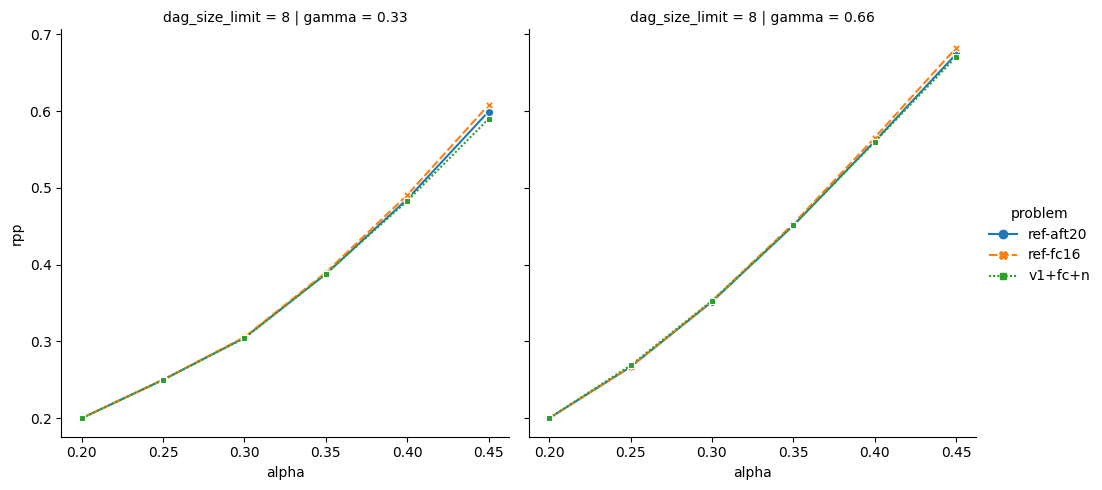

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="gamma",
    row="dag_size_limit",
)

In [9]:
!rm -f 7-rpp-for-alpha.csv

In [10]:
rpp_of_alpha = df.assign(
    column=lambda d: [
        f"{r.problem}:{r.protocol}:gamma{str(r.gamma)[2:]}:dsl{r.dag_size_limit:02d}"
        for _, r in d.iterrows()
    ]
).pivot(index="alpha", columns="column", values="rpp")
rpp_of_alpha.to_csv("7-rpp-of-alpha.csv")
rpp_of_alpha

column,ref-aft20:bitcoin:gamma33:dsl08,ref-aft20:bitcoin:gamma66:dsl08,ref-fc16:bitcoin:gamma33:dsl08,ref-fc16:bitcoin:gamma66:dsl08,v1+fc+n:bitcoin:gamma33:dsl08,v1+fc+n:bitcoin:gamma66:dsl08
alpha,,,,,,
0.20,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
0.25,0.250000,0.266765,0.250000,0.266976,0.250000,0.268812
0.30,0.304783,0.351688,0.305675,0.352632,0.304309,0.352815
0.35,0.387843,0.451141,0.389791,0.453313,0.387973,0.451487
0.40,0.485434,0.560800,0.490785,0.565413,0.483064,0.559826
0.45,0.599538,0.674380,0.608072,0.682474,0.590017,0.670778
